# stock-prediction-with-ML

## 1. 주제 : 수개월 후 코스피보다 많이 오를 주식 예측
## 2. 목표 : 특정 주식의 특정 시점 데이터를 넣었을 때, 해당 주식이 미래에 코스피 지수보다 더 오를지, 덜 오를지 '분류'하는 모델 생성
- 모델 종류 : 이진 분류
- Target
    - 0 : 고른 종목(데이터)이 6개월 뒤 KOSPI보다 낮은 수익률을 보였다.
    - 1 : 고른 종목이 6개월 뒤 KOSPI보다 높은 수익률을 보였다.
    
    
## 3. 데이터
- 분석 종목 : 2003년 기준 시가총액 상위 400위 기업(데이터 누수를 피하기 위해 현재 기준으로 하지 않음)
- 종류  
    1) 시가총액 데이터 : 한국거래소  
    2) 주가 변동 데이터 : 2003년 ~ 현재, `FinanceDataReader` 라이브러리 사용  
    3) 종목에 따른 연도별 PER, PBR, 배당수익률 데이터 : 한국거래소
    
## 4. Feature
- 미래의 주가에 영향을 끼칠 것이라 예상되는 것들로 선정
- 종류  
    1) 12개월 간 수익률 : 최근 12개월 간 수익률이 얼마나 났는가 (float)  
    2) KOSPI대비 12개월 간 수익률 : 최근 12개월 간 KOSPI 대비 수익률이 얼마나 났는가 (float)  
    3) 12개월 간 KOSPI 이김 : 최근 12개월 간 KOSPI 대비 수익률이 높았는가 (binary)  
    4) PER_inv : 해당 종목, 해당 시점의 PER의 역수 (float)  
    5) PBR_inv : 해당 종목, 해당 시점의 PBR의 역수 (float)  
    6) 배당수익률 : 주주에게 배분된 배당금과 주주가 갖고 있는 주식 가치의 비 (float)
   
    
 (* PER, PBR은 시가총액과 당기순이익, 자본의 비)
 
 
 ## 5. 가설
 - Feature와 Target 사이에는 시간에 독립적인 관계가 있다.
 - 따라서 시간에 관계 없이 종목의 feature, target 데이터만 있으면 모델을 학습시키고, 결과를 예측할 수 있다.

# 1. 데이터 수집
- 2003년 기준 시가총액 상위 400 종목

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import FinanceDataReader as fdr
# import dart_fss as dart
import warnings
import eli5
import yfinance as yf
from eli5.sklearn import PermutationImportance
from datetime import datetime, timedelta
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score, plot_confusion_matrix, roc_curve, roc_auc_score, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score


warnings.filterwarnings(action='ignore')
%matplotlib inline
# mpl.rc("font", family='Malgun Gothic') # 윈도우
mpl.rc('font', family='AppleGothic') #맥

plt.style.use('ggplot')
# pd.options.display.max_rows = 500

In [29]:
# 2003년부터 PER, PBR이 기입돼 있어서 2003년부터
# 상반기용
# date_list = ['20030102', '20040102', '20050102', '20060102', '20070102', '20080102', '20090102'
#              , '20110102', '20120102', '20130102', '20140102', '20150102'
#              , '20160102', '20170102', '20180102', '20190102', '20200102']
# date_list_for_PER = date_list + ['20210102'] # 왜 date_list보다 하나를 더 넣었을까... 별 의미 없었을 것 같기도...(당시 처음 코드를 짤 때(21년 11월) )
# PATH = './data'

# seasonnal 전체 데이터
# date_list = ['20031101', '20041101', '20051101', '20061101', '20071101', '20081101', '20091101'
#              , '20111101', '20121101', '20131101', '20141101', '20151101'
#              , '20161101', '20171101', '20181101', '20191101', '20201101']
# date_list_for_PER = date_list + ['20211101'] 

# 검증용 모델 생성
date_list = ['20031101', '20041101', '20051101', '20061101', '20071101', '20081101', '20091101'
             , '20111101', '20121101', '20131101', '20141101', '20151101'
             , '20161101', '20171101', '20181101', '20191101']
date_list_for_PER = date_list

PATH = './data_seasonal'

date_start = date_list[0]

N = 600 # 시가총액 상위 N 종목

df = pd.read_csv(f'{PATH}/{date_start}_total_stock.csv', encoding='euc-kr')

# 시가총액 상위 N종목 코드 리스트
top_code = df.sort_values(by='시가총액', ascending=False).head(N).종목코드.to_list()

# 종목코드를 가지고 종목명을 찾을 수 있는 dictionary
code_to_name_dic = df[['종목코드', '종목명']].set_index('종목코드').to_dict()['종목명']

# KOSPI = fdr.DataReader('KS11', date_start) # fdr이 안 돼서 yf 사용
KOSPI = yf.download('^KS11', date_start[:4]+'-'+date_start[4:6] + '-' + date_start[6:])

# 종목코드별 주가 데이터 dictionary에 저장
stock_price_dic = {}
for code in top_code:
    stock_price_dic[code] = fdr.DataReader(code, date_start)

[*********************100%***********************]  1 of 1 completed


# 2. 데이터 가공하기 및 엔지니어링

In [30]:
def date_add(date, month):
    '''date에 month만큼 더해준다. date는 20210102와 같은 꼴이나 datetime type으로 입력한다.'''
    if type(date) == str: # date가 datetime이 아니라 str 타입으로 들어온 경우
        date = datetime.strptime(date, '%Y%m%d')
    delta = timedelta(days=month*30.5)
    return date + delta

print('date_add 함수 테스트 : {}'.format(date_add(date_start, 12)))


def earning_rate(stock_price : list, start_date, end_date):
    '''start_date부터 end_date까지 stock_price데이터를 가지고 수익률을 구해주는 함수(종가 기준)'''
    possible_start_date = stock_price[stock_price.index >= start_date].index[0]
    possible_end_date = stock_price[stock_price.index <= end_date].index[-1]
    
    start_price = stock_price.loc[possible_start_date].Close
    end_price = stock_price.loc[possible_end_date].Close
    
    return (end_price - start_price) / start_price
    
sample_stock_price = stock_price_dic[top_code[0]]

print('수익률 함수 테스트 : {:.4f}%'.format(earning_rate(sample_stock_price, '20170101', '20170603')*100))


def plot_stock(stock_price_dic : dict, code : str) -> None :
    '''stock_price_dic과 종목 code를 받으면 주가 변동을 그려주는 함수(종가 기준)'''
    plt.plot(stock_price_dic[code].Close)
    plt.xlabel('date')
    plt.ylabel('원')
    plt.title(code_to_name_dic[code])

date_add 함수 테스트 : 2004-11-01 00:00:00
수익률 함수 테스트 : 27.3130%


1위


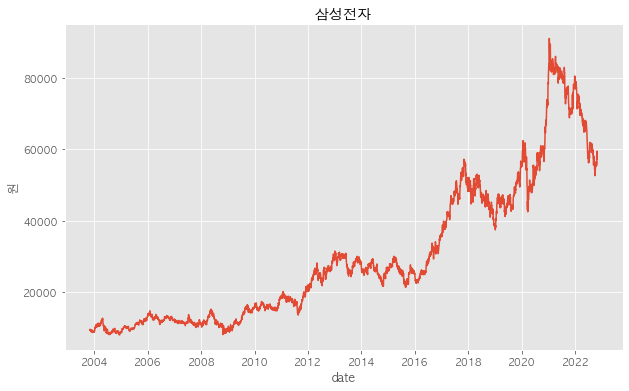

2위


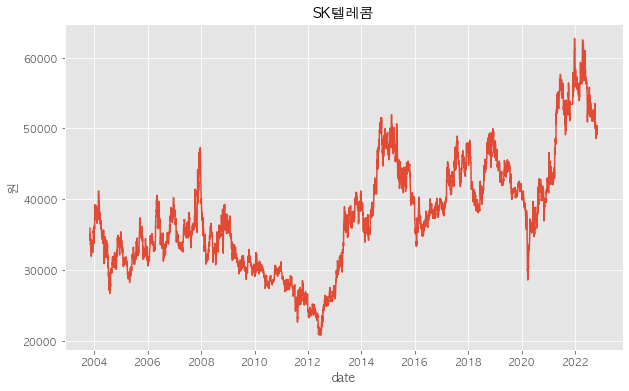

3위


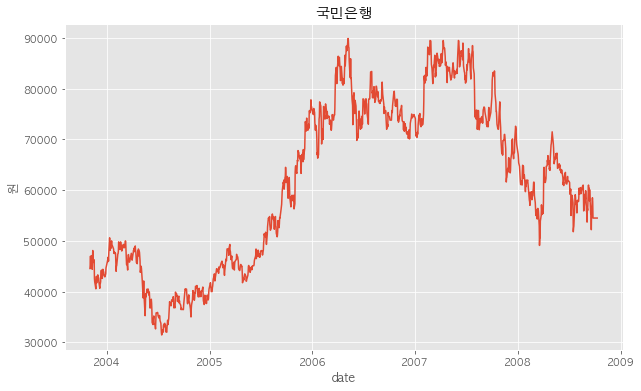

4위


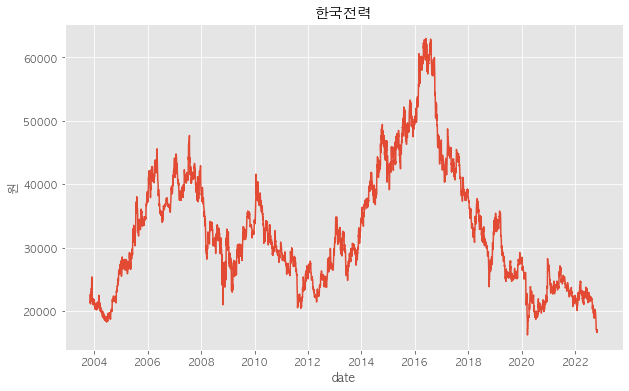

5위


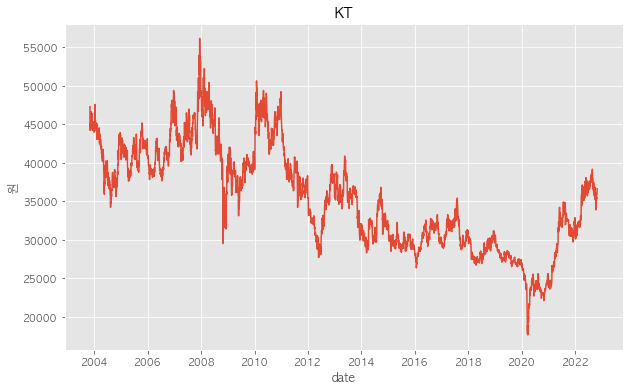

In [31]:
for i, code in enumerate(top_code[:5]):
    plt.figure(figsize=(10,6))
    plot_stock(stock_price_dic, code)
    print('{}위'.format(i+1))
    plt.show()

In [32]:
stock_price = stock_price_dic[top_code[0]]
stock_price.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2003-11-03,9400,9500,9330,9490,360846,0.009574
2003-11-04,9600,9690,9480,9580,815874,0.009484
2003-11-05,9480,9610,9440,9600,594854,0.002088
2003-11-06,9600,9610,9280,9300,646559,-0.031250
2003-11-07,9400,9540,9360,9540,379139,0.025806


In [33]:
n = 12 # n개월 간의 주가 추이 확인
m = 6 # m개월 후의 수익률 확인

def ER_list_return(stock_price, n=n, m=m, date_list=date_list):
    '''stock_price정보를 가지고 base_date 기준 n개월 전, m개월 후 수익률(Earning Rate)을 구해준다.
    return : 데이터로 사용할 수익률, target을 구할 때 사용할 수익률, base_date'''
    earning_rate_list = []
    target_list = []
    base_date_list = []  # 수익률 기준일
    
    periods = 12//n # n = 2개월이면 12개월을 6개로 쪼개는 식
    for date in date_list:
        try:
            for period in range(periods): 
                date_start = date_add(date, period*n)
                date_end = date_add(date_start, n)
                
                ER_before = earning_rate(stock_price, date_start, date_end)
                ER_after = earning_rate(stock_price, date_end, date_add(date_end, m))
                
                earning_rate_list.append(ER_before)
                target_list.append(ER_after)
                base_date_list.append(date_end)
                
        except: # 종목코드가 바뀌거나 상장폐지돼서 주가 데이터가 없는 경우가 있는 것 같음. 이를 고려             
            break

    return earning_rate_list, target_list, base_date_list


# DataFrame 만들기 위해 모든 종목들에 대해 시행해주기
n_month_ER_data = []
m_month_ER_data = []
date_data = []
code_data = []

for code in top_code:
    stock_price = stock_price_dic[code]
    earning_rate_list, target_list, base_date_list = ER_list_return(stock_price)
    n_month_ER_data += earning_rate_list
    m_month_ER_data += target_list
    date_data += base_date_list
    code_data += [code]*len(base_date_list)

In [34]:
data = pd.DataFrame({
                     'date' : date_data,
                     'code' : code_data,
                     f'{n}개월 간 수익률': n_month_ER_data,
                     f'{m}개월 후 수익률' : m_month_ER_data
                    })

data['name'] = data.code.apply(lambda x: code_to_name_dic[x])

KOSPI_n_earning, KOSPI_m_earning, KOSPI_base_date = ER_list_return(KOSPI)

KOSPI_data = pd.DataFrame({
                     'date' : KOSPI_base_date,
                     f'KOSPI {n}개월 간 수익률': KOSPI_n_earning,
                     f'KOSPI {m}개월 후 수익률' : KOSPI_m_earning
                    })

data = data.merge(KOSPI_data, on='date')

# KOSPI 대비 수입률 Feature 만들기
data[f'KOSPI대비 {n}개월 간 수익률'] = data[f'{n}개월 간 수익률'] - data[f'KOSPI {n}개월 간 수익률']
data[f'KOSPI대비 {m}개월 후 수익률'] = data[f'{m}개월 후 수익률'] - data[f'KOSPI {m}개월 후 수익률']
data[f'{n}개월 간 KOSPI 이김'] = data[f'KOSPI대비 {n}개월 간 수익률'].apply(lambda x: 1 if x>=0 else 0)
data[f'KOSPI보다 많이 오름'] = data[f'KOSPI대비 {m}개월 후 수익률'].apply(lambda x: 1 if x>=0 else 0)



# PER 파일 불러와서 dic에 저장
df_PER_dic = {}
for date in date_list_for_PER:
    # 결측치는 0으로
    df_PER_dic[date] = pd.read_csv(f'{PATH}/{date}_PER_PBR.csv', encoding='euc-kr')
    df_PER_dic[date][['PER', 'PBR']] = df_PER_dic[date][['PER', 'PBR']].fillna(10000)
    df_PER_dic[date][['배당수익률']] = df_PER_dic[date][['배당수익률']].fillna(0)

def near_date_for_PER(date, date_list=date_list_for_PER):
    '''한국거래소에서 받은 PER를 데이터 누수(미래의 PER 사용;) 없이 사용하기 위해 date에 따라 적절한 사용가능 날짜를 date_list에서 뽑아 리턴.
    date는 datetime 타입'''
    for d in date_list:
        d = datetime.strptime(d, '%Y%m%d')
        if d - timedelta(days=30) <= date < d + timedelta(days=336):
            return d.strftime('%Y%m%d')
    return date_list[0]

# near_date_for_PER(data.date[0])

def search_for_PER(code, date):
    '''code와 date 조건에 맞는 데이터를 PER가 담긴 df에서 찾아줌'''
    if type(date) != str:
        date = near_date_for_PER(date)
    df = df_PER_dic[date]
    cond = df['종목코드'] == code
    
    if cond.sum() == 0:
        fake_data = [0] * len(df.columns)
        return pd.DataFrame([fake_data], columns=df.columns)
    return df[cond]

# search_for_PER('069117', '20110102')

temp_df_list = []
for date, code in zip(data.date, data.code):
    temp_df_list.append(search_for_PER(code, date))
data_PER = pd.concat(temp_df_list, ignore_index=True)

data = pd.concat([ data, data_PER[['PER', 'PBR', '배당수익률']] ], axis=1)
data['PER_inv'] = 1/data['PER']
data['PBR_inv'] = 1/data['PBR']

data = data.drop(data[data['PER_inv']==np.inf].index) # 이유는 모르겠지만 PER_inv에 inf값이 껴있음...(seasonal 모델 생성 시도부터..)

data.head(3)

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
0,2004-11-01,005930,-0.073762,0.035267,삼성전자,0.055179,0.093531,-0.128941,-0.058264,0,0,12.09,2.41,1.25,0.082713,0.414938
1,2004-11-01,017670,-0.129821,-0.071824,SK텔레콤,0.055179,0.093531,-0.185000,-0.165355,0,0,6.99,2.24,3.04,0.143062,0.446429
2,2004-11-01,060000,-0.140292,0.104439,국민은행,0.055179,0.093531,-0.195471,0.010908,0,1,10000.00,1.39,0.00,0.000100,0.719424


In [35]:
data.shape

(7994, 16)

# 3. 모델링 및 예측

In [37]:
features = [f'{n}개월 간 수익률', f'KOSPI대비 {n}개월 간 수익률', f'{n}개월 간 KOSPI 이김', 'PER_inv', 'PBR_inv', '배당수익률']
targets = ['3개월 후 수익률', 'KOSPI대비 3개월 후 수익률', 'KOSPI보다 많이 오름'] # 얘네들을 feature에 넣으면 Data leakage가 발생하게 됨
target = ['KOSPI보다 많이 오름']

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# basline model 정의
target_mode = y_train['KOSPI보다 많이 오름'].value_counts(normalize=True).sort_values(ascending=False).index[0]
baseline_model = [1] * len(y_test) # precision check를 위해 baseline model은 1로

In [38]:
# Logistic Regression을 이용한 모델
pipe = make_pipeline(
#               OrdinalEncoder()
#             , SimpleImputer(strategy='mean')
            LogisticRegression()
            )
pipe.fit(X_train.values, y_train.values.ravel());
y_pred = pipe.predict(X_test.values)
y_proba = pipe.predict_proba(X_test.values)[:, 1]

threshold = 0.65
y_pred_thres = np.array(list(map(lambda x: 0 if x < threshold else 1, y_proba)))

print('Baseline model Precision score : {:.4f}'.format(precision_score(y_test, baseline_model)))
print('Model Cross Vlidation Precision score : {:.4f}'.format(cross_val_score(pipe, X.values, y.values.ravel(), cv=5, scoring='precision').mean()))
print('Model Precision score(Test set) : {:.4f}'.format(precision_score(y_test, y_pred)))
print('Threshold adjusted Model Precision score : {:.4f}'.format(precision_score(y_test, y_pred_thres)))
print('만약 threshold값 이상의 종목을 사고 {}개월 뒤 판매했다면? 기대 수익률 {:.2f}%'.format(m, data.loc[X_test[y_proba > threshold].index][f'{m}개월 후 수익률'].mean()*100))

Baseline model Precision score : 0.4953
Model Cross Vlidation Precision score : 0.5598
Model Precision score(Test set) : 0.5319
Threshold adjusted Model Precision score : 0.7049
만약 threshold값 이상의 종목을 사고 6개월 뒤 판매했다면? 기대 수익률 53.64%


In [39]:
# 모델이 코스피보다 높은 수익률을 보일 것이라 예측한 데이터
data.loc[X_test[y_proba > threshold].index].sort_values(by='date').tail(5)

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
2371,2008-11-01,001940,-0.796815,1.003514,한국철강,-0.460502,0.212810,-0.336313,0.790703,0,1,2.53,0.23,3.17,0.395257,4.347826
2365,2008-11-01,003920,-0.556667,0.272050,남양유업,-0.460502,0.212810,-0.096165,0.059239,0,1,4.84,0.54,0.24,0.206612,1.851852
2708,2008-11-01,002920,-0.523774,0.326382,유성기업,-0.460502,0.212810,-0.063272,0.113571,0,1,3.68,0.32,5.06,0.271739,3.125000
5000,2014-11-02,005960,-0.639812,-0.272210,동부건설,-0.036770,0.091788,-0.603041,-0.363999,0,0,10000.00,0.15,0.00,0.000100,6.666667
6926,2018-11-02,000950,-0.111392,0.042735,전방,-0.180119,0.047863,0.068727,-0.005128,1,0,10000.00,0.20,2.85,0.000100,5.000000


In [40]:
# Random Forest를 이용한 모델
pipe = make_pipeline(
#               OrdinalEncoder()
#             , SimpleImputer(strategy='mean')
            RandomForestClassifier(n_estimators=150, min_samples_leaf=2, random_state=10
                                     , oob_score=True, n_jobs=-1)
            )
pipe.fit(X_train.values, y_train.values.ravel());
y_pred = pipe.predict(X_test.values)
y_proba = pipe.predict_proba(X_test.values)[:, 1]

threshold = 0.65
y_pred_thres = np.array(list(map(lambda x: 0 if x < threshold else 1, y_proba)))

print('Baseline model Precision score : {:.4f}'.format(precision_score(y_test, baseline_model)))
print('Model Cross Vlidation Precision score : {:.4f}'.format(cross_val_score(pipe, X.values, y.values.ravel(), cv=5, scoring='precision').mean()))
print('Model Precision score(Test set) : {:.4f}'.format(precision_score(y_test, y_pred)))
print('Threshold adjusted Model Precision score : {:.4f}'.format(precision_score(y_test, y_pred_thres)))
print('만약 threshold값 이상의 종목을 사고 {}개월 뒤 판매했다면? 기대 수익률 : {:.2f}%'.format(m, data.loc[X_test[y_proba > threshold].index][f'{m}개월 후 수익률'].mean()*100))

Baseline model Precision score : 0.4953
Model Cross Vlidation Precision score : 0.5203
Model Precision score(Test set) : 0.5473
Threshold adjusted Model Precision score : 0.6250
만약 threshold값 이상의 종목을 사고 6개월 뒤 판매했다면? 기대 수익률 : 26.73%


In [41]:
# 모델이 코스피보다 높은 수익률을 보일 것이라 예측한 데이터
data.loc[X_test[y_proba > threshold].index].sort_values(by='date').tail()

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
7803,2020-11-01,003570,-0.134775,0.547170,통일중공업,0.079492,0.359558,-0.214268,0.187612,0,1,10000.00,10000.00,0.00,0.000100,0.000100
7584,2020-11-01,024110,-0.313445,0.127962,기업은행,0.079492,0.359558,-0.392938,-0.231596,0,0,6.35,10000.00,0.00,0.157480,0.000100
7566,2020-11-01,005380,0.326613,0.278592,현대차,0.079492,0.359558,0.247120,-0.080965,1,0,6.36,1.08,2.10,0.157233,0.925926
7564,2020-11-01,030200,-0.169173,0.272931,KT,0.079492,0.359558,-0.248665,-0.086627,0,0,6.24,1.05,1.82,0.160256,0.952381
7727,2020-11-01,056190,-0.135714,0.136426,에스에프에이,0.079492,0.359558,-0.215207,-0.223132,0,0,13.42,10000.00,0.00,0.074516,0.000100


# Grid SearchCV 를| 통한 하이퍼 파라미터 튜닝

In [42]:
# GridSearchCV

pipe = make_pipeline(
            RandomForestClassifier(random_state=10, oob_score=True, n_jobs=-1)
            )

dists = {
    'randomforestclassifier__n_estimators' : [150, 300, 600],
    'randomforestclassifier__min_samples_leaf' : [2, 3, 4],
}

clf = GridSearchCV(
    pipe,
    param_grid=dists,
    cv=3,
    scoring='precision',
    verbose=1,
    n_jobs=-1    
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/yoonwookye/opt/anaconda3/envs/project3/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/yoonwookye/opt/anaconda3/envs/project3/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/yoonwookye/opt/anaconda3/envs/project3/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/yoonwookye/opt/anaconda3/envs/project3/lib/python3.8/s

In [43]:
print('Optimized Hyper parameters : {}'.format(clf.best_params_))
print('Best precision score : {}'.format(clf.best_score_))

best_model = clf.best_estimator_

y_pred = best_model.predict(X_test.values)
y_proba = best_model.predict_proba(X_test.values)[:, 1]

threshold = 0.65
y_pred_thres = np.array(list(map(lambda x: 0 if x < threshold else 1, y_proba)))

print()
print('Baseline model Precision score : {:.4f}'.format(precision_score(y_test, baseline_model)))
print('Model Cross Vlidation Precision score : {:.4f}'.format(cross_val_score(best_model, X.values, y.values.ravel(), cv=5, scoring='precision').mean()))
print('Model Precision score(Test set) : {:.4f}'.format(precision_score(y_test, y_pred)))
print('Threshold adjusted Model Precision score : {:.4f}'.format(precision_score(y_test, y_pred_thres)))
print('만약 threshold값 이상의 종목을 사고 {}개월 뒤 판매했다면? 기대 수익률 : {:.2f}%'.format(m, data.loc[X_test[y_proba > threshold].index][f'{m}개월 후 수익률'].mean()*100))

Optimized Hyper parameters : {'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 150}
Best precision score : 0.555373958973228

Baseline model Precision score : 0.4953
Model Cross Vlidation Precision score : 0.5192
Model Precision score(Test set) : 0.5497
Threshold adjusted Model Precision score : 0.6480
만약 threshold값 이상의 종목을 사고 6개월 뒤 판매했다면? 기대 수익률 : 28.22%


In [44]:
# 모델이 코스피보다 높은 수익률을 보일 것이라 예측한 데이터
data.loc[X_test[y_proba > threshold].index].sort_values(by='date').tail(5)

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
7966,2020-11-01,001630,0.040685,0.079137,종근당,0.079492,0.359558,-0.038807,-0.280421,0,0,10000.00,0.37,0.0,0.000100,2.702703
7763,2020-11-01,072710,-0.166858,0.102098,농심홀딩스,0.079492,0.359558,-0.246351,-0.257460,0,0,10000.00,10000.00,0.0,0.000100,0.000100
7584,2020-11-01,024110,-0.313445,0.127962,기업은행,0.079492,0.359558,-0.392938,-0.231596,0,0,6.35,10000.00,0.0,0.157480,0.000100
7566,2020-11-01,005380,0.326613,0.278592,현대차,0.079492,0.359558,0.247120,-0.080965,1,0,6.36,1.08,2.1,0.157233,0.925926
7803,2020-11-01,003570,-0.134775,0.547170,통일중공업,0.079492,0.359558,-0.214268,0.187612,0,1,10000.00,10000.00,0.0,0.000100,0.000100


# 4. 어떤 Feature가 어떤 역할을 했을까?(모델 분석)

## 1) Permutation Importance

In [45]:
# permuter 정의
permuter = PermutationImportance(
    best_model, # model
    scoring='precision', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_train, y_train);

feature_names = X_train.columns.tolist()
# pd.Series(permuter.feature_importances_, feature_names).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.2616 ± 0.0047,PBR_inv
0.2188 ± 0.0112,12개월 간 수익률
0.2101 ± 0.0138,PER_inv
0.2016 ± 0.0064,KOSPI대비 12개월 간 수익률
0.1818 ± 0.0092,배당수익률
0.0108 ± 0.0029,12개월 간 KOSPI 이김


# 5. 결론
- 1년동안 많이 올랐으면 다음에도 많이 안 오를 수 있다.
- KOSPI가 떨어질 때 오르거나 유지한(코스피를 이긴) 종목이 진짜다.
- 역시 PBR, PER가 낮을 수록 좋다. 특히 PBR이 더 큰 영향.

#### *현재 기준 1년간 수익률, PER, PBR, 배당수익률을 바탕으로  6개월 뒤 KOSPI보다 오를 주식을 어느 정도 찾을 수 있다.*

# 6. 한계점
- 추가적인 Feature Engineering을 통해 모델 성능을 향상시킬 여지가 매우 많으나, 시간이 부족해 하지 못했다.
- 데이터 누수를 피하기 위해 2003년의 시가총액 상위 기업들만 대상으로 분석을 진행해 신규 회사들을 학습, 예측하지 못했다.
- 모델의 성능을 dramatic하게 올리진 못했으며, threshold 조정에 따른 precision score의 편차가 커서 일반화하기 어렵다.

In [27]:
data.to_csv('past_purified_data.csv',encoding='euc-kr')

In [46]:
best_model

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=4, n_estimators=150,
                                        n_jobs=-1, oob_score=True,
                                        random_state=10))])

In [47]:
# 모델 내보내기(피클화하기)
import pickle

with open('model.pkl','wb') as pickle_file:
    pickle.dump(best_model, pickle_file)